In [3]:

#Genetic _Algorithms

#active user 10
#neighbour 5
errror_g=[]
f1_s=[]
pre_s=[]
mae_s=[]
recall_s=[]

0
Iteration :  0
Error:  0.7096471749321492
1
Iteration :  1
Error:  0.7243162988772742
2
Iteration :  2
Error:  0.6617020332060727
3
Iteration :  3
Error:  0.8681790541387701
4
Iteration :  4
Error:  0.9026684747973264
5
Iteration :  5
Error:  0.8795741652983031
6
Iteration :  6
Error:  0.9570669861235896
7
Iteration :  7
Error:  0.6996036775504465
8
Iteration :  8
Error:  0.9903002095562269
9
Iteration :  9
Error:  0.8978013172724708
Mean absolute error for all iterations:  0.829085939175263


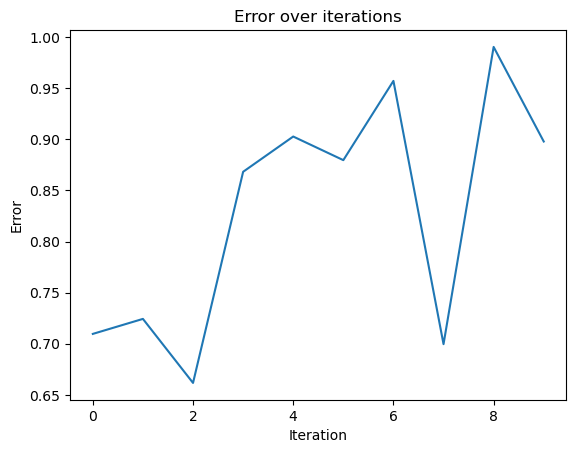

3.4393491124260356
---------------------------------


In [4]:
def genetic():
    f1_=[]
    precison_g=[]
    genetic_error=[]
    recall_g=[]
    mae_g=[]


    from sklearn.metrics import f1_score,precision_score,recall_score
    from sklearn.preprocessing import LabelEncoder
# Import pandas and numpy
    import pandas as pd
    import numpy as np
    import operator
    import matplotlib.pyplot as plt

    from settings import NO_OF_GENRES, NO_OF_FEATURES
    import load_data
    import fuzzy_sets
    import gim
    from genetic import genetic_optimize, cost_function
    from Flowe_2 import flower_pollination_algorithm, cost_function;
    from flower import flower_pollination_optimize, cost_function
# Constants
    WEIGHTS=np.random.rand(NO_OF_FEATURES)
    NO_OF_ITERATIONS=10
    NO_OF_NEIGHBOURS=5

# namespace items_merged from load_data file
   items_merged = load_data.items_merged
 age = fuzzy_sets.Age()

# Create objects for Age and GIM to use for fuzzy sets
   
    gim_obj = fuzzy_sets.GIM()


m_cols = ['unknown', 'Action', 'Adventure',
          'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
          'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', 'age',
          'user_id']

# Initialize empty dataFrames for active and passive users
model_data_active_users = pd.DataFrame(columns=m_cols)
model_data_passive_users = pd.DataFrame(columns=m_cols)


def euclidean_dist(list_a, list_b):
    """Return the Euclidean distance between two array elements."""
    return np.linalg.norm(np.array(list_a) - np.array(list_b))


def fuzzy_dist(first_point, second_point, fuzzy_set_first_point, fuzzy_set_second_point):
    """Returns fuzzy distance between two values and their fuzzy sets."""
    return abs(first_point - second_point) * euclidean_dist(fuzzy_set_first_point, fuzzy_set_second_point)


def fuzzy_distance(ui, uj):
   
  
    """Returns fuzzy distance between given points."""

    fuzzy_dis = [0] * NO_OF_FEATURES

    # Get fuzzy set values for movie genres
    for i in range(0, NO_OF_GENRES):

        ui_gim = gim_obj.get_fuzzy_set(int(ui.iloc[i]))
        uj_gim = gim_obj.get_fuzzy_set(int(uj.iloc[i]))
        fuzzy_dis[i] =fuzzy_dist(int(ui.iloc[i]), int(uj.iloc[i]), ui_gim, uj_gim)

    # Get fuzzy set values for age
    ui_gim = age.get_fuzzy_set(int(ui.iloc[i]))
    uj_gim = age.get_fuzzy_set(int(uj.iloc[i]))  # specify the column name here
    fuzzy_dis[i] = fuzzy_dist(int(ui.iloc[i]),int(uj.iloc[i]), ui_gim, uj_gim)

    # adding user_id of second user
    fuzzy_dis[NO_OF_FEATURES-1] = uj['user_id']
    
    return fuzzy_dis


def get_neighbours(model_active_users, model_passive_users):
    # Save active users and its neighbours in a data-frame with active users' id as column name
    user_neighbours= pd.DataFrame(columns=model_active_users['user_id'])
    #print("user",user_neighbours)
    # Iterate over active users model and save neighbours of each active users in user_neighbours
    for _, value in model_active_users.iterrows():
        j = 0
        fuzzy_vec = []
        for _, value_p in model_passive_users.iterrows():
            fuzzy_vec.append(fuzzy_distance(value, value_p))
            #print("fuzzy_vec",fuzzy_vec)
            #print(WEIGHTS[:-1])
            fuzzy_gen_dist = np.abs(np.sum(np.multiply(WEIGHTS[:-1], np.array(fuzzy_vec[j][:-1]))))
            fuzzy_vec[j] = [fuzzy_gen_dist, fuzzy_vec[j][-1]]
            j = j + 1
        user_neighbours[value.iloc[-1]] = [n[1] for n in sorted(fuzzy_vec, key=operator.itemgetter(0), reverse=True)][:NO_OF_NEIGHBOURS]
    return user_neighbours


def model_for_users(users_data):
    """Create model for given users data i.e. merged movies, items, and users
    Args:
        users_data: DataFrame of merged movies, items, and users based on movie_id
    """
    i = 0
    model_data_for_users = pd.DataFrame(columns=m_cols)
    
    for _, curr_value in users_data.iterrows():
        #print(curr_value)
        # Get user movies based on user
        user_movies = items_merged.loc[items_merged['user_id'] == curr_value['user_id']]
        #print("user movie",user_movies)
        # Get feature list for all movies of one user
        feature_array = gim.gim_final(user_movies, curr_value['user_id'])
        feature_array[NO_OF_GENRES] = curr_value['age']
        feature_array[NO_OF_GENRES + 1] = curr_value['user_id']

        # Save current feature values in model data
        model_data_for_users.loc[i] = feature_array
        i = i + 1
    return model_data_for_users

def correction_prediction(actual_ratings, predicted_ratings):
    """Correct predicted ratings based on actual ratings."""

    # Compute errors between actual and predicted ratings
    errors =errors = [actual - predicted for actual, predicted in zip(actual_ratings, predicted_ratings)]

    # Calculate mean error
    mean_error = np.mean(errors)

    # Apply correction to predicted ratings
    corrected_predictions = np.array([predicted_rating + mean_error for predicted_rating in predicted_ratings])

    return corrected_predictions
def recommend(nearest_neighbours, test_users_data):
    """Recommend rating for given movies i.e. test_examples based on nearest neighbours.
     
    Also return actual and predicated ratings for testing users
    """
    # print("nearest_neighbours")
    # print(nearest_neighbours)
    # print("test_users_data")
    # print(test_users_data.head())
    predicated_rat=[]
    actual_rat = []
    for key, item in test_users_data.iterrows():
        #print(item)
        
        m_id = item['movie_id']
        n_ratings = []
        for i in nearest_neighbours:

            # Get items or movie details reviewed by neighbour i with given m_id
            temp = items_merged.loc[items_merged['user_id'] == i].loc[items_merged['movie_id'] == m_id]
            for k, it in temp.iterrows():
                n_ratings.append(it['rating'])
        predicated_rat.append(float(sum(n_ratings)) / len(n_ratings) if len(n_ratings) else 0)
        actual_rat.append(item['rating'])
    return actual_rat, predicated_rat

# Users who has rated movies at least 60 movies
top_users = load_data.items_merged.groupby('user_id').size().sort_values(ascending=False)[:497]
 
model_error = []
f=[]
re=[]
pre=[]

# Train model for given iterations
for i in range(0, NO_OF_ITERATIONS):
    print(i)

    # Get random 10% of the top_users as active users and remaining are passive users
    active_users = top_users.sample(frac=0.10)

    # Random 34% of active users will be used for training and 66% users for testing purpose.
    training_active_users = active_users.sample(frac=0.34)
    #testing_active_users = active_users.drop(training_active_users.index)

    # passive_users will be used as training examples
    passive_users = top_users.drop(active_users.index)

    # Get active and passive users' data from merged movies, items, and users
    training_active_users_data = items_merged.loc[items_merged['user_id'].isin(training_active_users)][:10]
    test_active_users_data = items_merged.loc[items_merged['user_id'].isin(training_active_users)][10:]
    passive_users_data = items_merged.loc[items_merged['user_id'].isin(passive_users)][:10]

    # Get model for active users
    model_data_active_users = model_for_users(training_active_users_data)

    # Get model for passive users
    model_data_passive_users = model_for_users(passive_users_data)

    # Get neighbour users of active users
    active_users_neighbours = get_neighbours(model_data_active_users, model_data_passive_users)

    # Recommend users based on neighbours
    actual_ratings, predicated_ratings=recommend(active_users_neighbours, test_active_users_data)

    # Get error for predictions of test users
    cur_error = cost_function(actual_ratings, predicated_ratings)

    # Optimize weights using genetic algorithm approach and update weighs
    WEIGHTS  =genetic_optimize(actual_ratings, predicated_ratings).flatten()
    # print(predicated_ratings)
    
    #WEIGHTS  =flower_pollination_optimize(actual_ratings, predicated_ratings).flatten()
    # Add current iteration error to model error for MAE of the model
    
    model_error.append(cost_function(actual_ratings, predicated_ratings))
    pred=[int(num) for num in predicated_ratings]
    f.append(f1_score(actual_ratings, pred, average='micro'))
    pre.append(precision_score(actual_ratings, pred, average='micro'))
    re.append(recall_score(actual_ratings, pred, average='micro'))
    # Log details for current iteration
    print("Iteration : ", i)
    print("Error: ", cur_error)
   
print("Mean absolute error for all iterations: ", sum(model_error)/len(model_error))
genetic_error=model_error
f1_=f
precison=pre
recall=re
mae=model_error
#average of erro overt the time 
plt.plot(model_error)
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title('Error over iterations')
plt.show()
print(np.mean(correction_prediction(actual_ratings, predicated_ratings)))
print("---------------------------------")
pred=[int(num) for num in predicated_ratings]
f1_s.append(f1_score(actual_ratings, pred, average='micro'))
pre_s.append(precision_score(actual_ratings, pred, average='micro'))
recall_s.append(recall_score(actual_ratings, pred, average='micro'))





# Assuming model_error is your list
# replace with your list

# Assuming model_error is your list
# replace with your list


0
Iteration :  0
Error:  0.9065522048572894
1
Iteration :  1
Error:  0.9473633955522703
2
Iteration :  2
Error:  0.7596551941870184
3
Iteration :  3
Error:  0.7984243209138611
4
Iteration :  4
Error:  0.7387001788667271
5
Iteration :  5
Error:  0.7208294092255768
6
Iteration :  6
Error:  0.679835941262668
7
Iteration :  7
Error:  0.9096074250595759
8
Iteration :  8
Error:  1.004684065934066
9
Iteration :  9
Error:  0.8628658096645893
Mean absolute error for all iterations:  0.8328517945523644


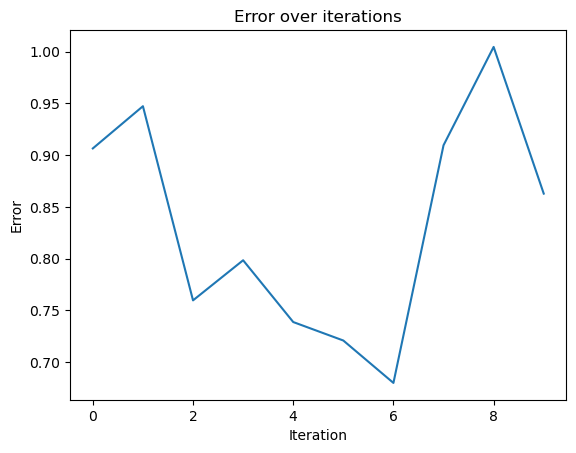

2.929046563192905
---------------------------------


In [5]:
f1_=[]
precison_g=[]
genetic_error=[]
recall_g=[]
mae_g=[]

from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn.preprocessing import LabelEncoder
# Import pandas and numpy
import pandas as pd
import numpy as np
import operator
import matplotlib.pyplot as plt

from settings import NO_OF_GENRES, NO_OF_FEATURES
import load_data
import fuzzy_sets
import gim
from genetic import genetic_optimize, cost_function
from Flowe_2 import flower_pollination_algorithm, cost_function;
from flower import flower_pollination_optimize, cost_function
# Constants
WEIGHTS=np.random.rand(NO_OF_FEATURES)
NO_OF_ITERATIONS=10
NO_OF_NEIGHBOURS=10

# namespace items_merged from load_data file
items_merged = load_data.items_merged

# Create objects for Age and GIM to use for fuzzy sets
age = fuzzy_sets.Age()
gim_obj = fuzzy_sets.GIM()

m_cols = ['unknown', 'Action', 'Adventure',
          'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
          'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', 'age',
          'user_id']

# Initialize empty dataFrames for active and passive users
model_data_active_users = pd.DataFrame(columns=m_cols)
model_data_passive_users = pd.DataFrame(columns=m_cols)


def euclidean_dist(list_a, list_b):
    """Return the Euclidean distance between two array elements."""
    return np.linalg.norm(np.array(list_a) - np.array(list_b))


def fuzzy_dist(first_point, second_point, fuzzy_set_first_point, fuzzy_set_second_point):
    """Returns fuzzy distance between two values and their fuzzy sets."""
    return abs(first_point - second_point) * euclidean_dist(fuzzy_set_first_point, fuzzy_set_second_point)


def fuzzy_distance(ui, uj):
   
  
    """Returns fuzzy distance between given points."""

    fuzzy_dis = [0] * NO_OF_FEATURES

    # Get fuzzy set values for movie genres
    for i in range(0, NO_OF_GENRES):

        ui_gim = gim_obj.get_fuzzy_set(int(ui.iloc[i]))
        uj_gim = gim_obj.get_fuzzy_set(int(uj.iloc[i]))
        fuzzy_dis[i] =fuzzy_dist(int(ui.iloc[i]), int(uj.iloc[i]), ui_gim, uj_gim)

    # Get fuzzy set values for age
    ui_gim = age.get_fuzzy_set(int(ui.iloc[i]))
    uj_gim = age.get_fuzzy_set(int(uj.iloc[i]))  # specify the column name here
    fuzzy_dis[i] = fuzzy_dist(int(ui.iloc[i]),int(uj.iloc[i]), ui_gim, uj_gim)

    # adding user_id of second user
    fuzzy_dis[NO_OF_FEATURES-1] = uj['user_id']
    
    return fuzzy_dis


def get_neighbours(model_active_users, model_passive_users):
    # Save active users and its neighbours in a data-frame with active users' id as column name
    user_neighbours= pd.DataFrame(columns=model_active_users['user_id'])
    #print("user",user_neighbours)
    # Iterate over active users model and save neighbours of each active users in user_neighbours
    for _, value in model_active_users.iterrows():
        j = 0
        fuzzy_vec = []
        for _, value_p in model_passive_users.iterrows():
            fuzzy_vec.append(fuzzy_distance(value, value_p))
            #print("fuzzy_vec",fuzzy_vec)
            #print(WEIGHTS[:-1])
            fuzzy_gen_dist = np.abs(np.sum(np.multiply(WEIGHTS[:-1], np.array(fuzzy_vec[j][:-1]))))
            fuzzy_vec[j] = [fuzzy_gen_dist, fuzzy_vec[j][-1]]
            j = j + 1
        user_neighbours[value.iloc[-1]] = [n[1] for n in sorted(fuzzy_vec, key=operator.itemgetter(0), reverse=True)][:NO_OF_NEIGHBOURS]
    return user_neighbours


def model_for_users(users_data):
    """Create model for given users data i.e. merged movies, items, and users
    Args:
        users_data: DataFrame of merged movies, items, and users based on movie_id
    """
    i = 0
    model_data_for_users = pd.DataFrame(columns=m_cols)
    
    for _, curr_value in users_data.iterrows():
        #print(curr_value)
        # Get user movies based on user
        user_movies = items_merged.loc[items_merged['user_id'] == curr_value['user_id']]
        #print("user movie",user_movies)
        # Get feature list for all movies of one user
        feature_array = gim.gim_final(user_movies, curr_value['user_id'])
        feature_array[NO_OF_GENRES] = curr_value['age']
        feature_array[NO_OF_GENRES + 1] = curr_value['user_id']

        # Save current feature values in model data
        model_data_for_users.loc[i] = feature_array
        i = i + 1
    return model_data_for_users

def correction_prediction(actual_ratings, predicted_ratings):
    """Correct predicted ratings based on actual ratings."""

    # Compute errors between actual and predicted ratings
    errors =errors = [actual - predicted for actual, predicted in zip(actual_ratings, predicted_ratings)]

    # Calculate mean error
    mean_error = np.mean(errors)

    # Apply correction to predicted ratings
    corrected_predictions = np.array([predicted_rating + mean_error for predicted_rating in predicted_ratings])

    return corrected_predictions
def recommend(nearest_neighbours, test_users_data):
    """Recommend rating for given movies i.e. test_examples based on nearest neighbours.
     
    Also return actual and predicated ratings for testing users
    """
    # print("nearest_neighbours")
    # print(nearest_neighbours)
    # print("test_users_data")
    # print(test_users_data.head())
    predicated_rat=[]
    actual_rat = []
    for key, item in test_users_data.iterrows():
        #print(item)
        
        m_id = item['movie_id']
        n_ratings = []
        for i in nearest_neighbours:

            # Get items or movie details reviewed by neighbour i with given m_id
            temp = items_merged.loc[items_merged['user_id'] == i].loc[items_merged['movie_id'] == m_id]
            for k, it in temp.iterrows():
                n_ratings.append(it['rating'])
        predicated_rat.append(float(sum(n_ratings)) / len(n_ratings) if len(n_ratings) else 0)
        actual_rat.append(item['rating'])
    return actual_rat, predicated_rat

# Users who has rated movies at least 60 movies
top_users = load_data.items_merged.groupby('user_id').size().sort_values(ascending=False)[:497]
 
model_error = []
f=[]
re=[]
pre=[]

# Train model for given iterations
for i in range(0, NO_OF_ITERATIONS):
    print(i)

    # Get random 10% of the top_users as active users and remaining are passive users
    active_users = top_users.sample(frac=0.10)

    # Random 34% of active users will be used for training and 66% users for testing purpose.
    training_active_users = active_users.sample(frac=0.34)
    #testing_active_users = active_users.drop(training_active_users.index)

    # passive_users will be used as training examples
    passive_users = top_users.drop(active_users.index)

    # Get active and passive users' data from merged movies, items, and users
    training_active_users_data = items_merged.loc[items_merged['user_id'].isin(training_active_users)][:10]
    test_active_users_data = items_merged.loc[items_merged['user_id'].isin(training_active_users)][10:]
    passive_users_data = items_merged.loc[items_merged['user_id'].isin(passive_users)][:10]

    # Get model for active users
    model_data_active_users = model_for_users(training_active_users_data)

    # Get model for passive users
    model_data_passive_users = model_for_users(passive_users_data)

    # Get neighbour users of active users
    active_users_neighbours = get_neighbours(model_data_active_users, model_data_passive_users)

    # Recommend users based on neighbours
    actual_ratings, predicated_ratings=recommend(active_users_neighbours, test_active_users_data)

    # Get error for predictions of test users
    cur_error = cost_function(actual_ratings, predicated_ratings)

    # Optimize weights using genetic algorithm approach and update weighs
    WEIGHTS  =genetic_optimize(actual_ratings, predicated_ratings).flatten()
    # print(predicated_ratings)
    
    #WEIGHTS  =flower_pollination_optimize(actual_ratings, predicated_ratings).flatten()
    # Add current iteration error to model error for MAE of the model
    
    model_error.append(cost_function(actual_ratings, predicated_ratings))
    pred=[int(num) for num in predicated_ratings]
    f.append(f1_score(actual_ratings, pred, average='micro'))
    pre.append(precision_score(actual_ratings, pred, average='micro'))
    re.append(recall_score(actual_ratings, pred, average='micro'))
    # Log details for current iteration
    print("Iteration : ", i)
    print("Error: ", cur_error)
   
print("Mean absolute error for all iterations: ", sum(model_error)/len(model_error))
genetic_error=model_error
f1_=f
precison=pre
recall=re
mae=model_error
#average of erro overt the time 
plt.plot(model_error)
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title('Error over iterations')
plt.show()
print(np.mean(correction_prediction(actual_ratings, predicated_ratings)))
print("---------------------------------")
pred=[int(num) for num in predicated_ratings]
f1_s.append(f1_score(actual_ratings, pred, average='micro'))
pre_s.append(precision_score(actual_ratings, pred, average='micro'))
recall_s.append(recall_score(actual_ratings, pred, average='micro'))


0
Iteration :  0
Error:  0.5887646652864046
1
Iteration :  1
Error:  0.8344609716627067
2
Iteration :  2
Error:  0.855549695264885
3
Iteration :  3
Error:  0.8228338988177425
4
Iteration :  4
Error:  0.6671006642721969
5
Iteration :  5
Error:  0.7533998337489609
6
Iteration :  6
Error:  0.9845926304756858
7
Iteration :  7
Error:  0.8959063363907649
8
Iteration :  8
Error:  0.6422497215260374
9
Iteration :  9
Error:  0.6528629233845772
Mean absolute error for all iterations:  0.7697721340829963


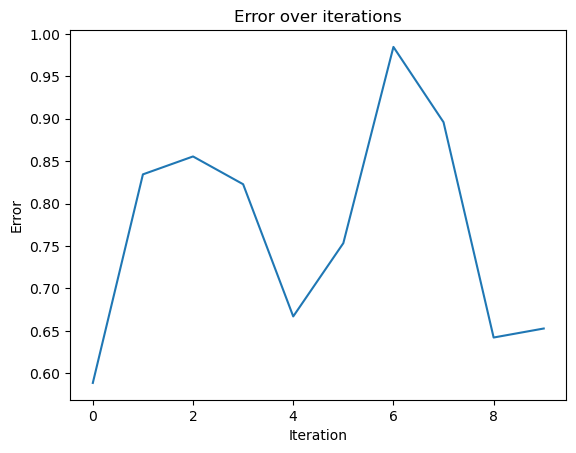

3.656988188976378
---------------------------------


In [6]:
f1_=[]
precison_g=[]
genetic_error=[]
recall_g=[]
mae_g=[]

from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn.preprocessing import LabelEncoder
# Import pandas and numpy
import pandas as pd
import numpy as np
import operator
import matplotlib.pyplot as plt

from settings import NO_OF_GENRES, NO_OF_FEATURES
import load_data
import fuzzy_sets
import gim
from genetic import genetic_optimize, cost_function
from Flowe_2 import flower_pollination_algorithm, cost_function;
from flower import flower_pollination_optimize, cost_function
# Constants
WEIGHTS=np.random.rand(NO_OF_FEATURES)
NO_OF_ITERATIONS=10
NO_OF_NEIGHBOURS=15

# namespace items_merged from load_data file
items_merged = load_data.items_merged

# Create objects for Age and GIM to use for fuzzy sets
age = fuzzy_sets.Age()
gim_obj = fuzzy_sets.GIM()

m_cols = ['unknown', 'Action', 'Adventure',
          'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
          'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', 'age',
          'user_id']

# Initialize empty dataFrames for active and passive users
model_data_active_users = pd.DataFrame(columns=m_cols)
model_data_passive_users = pd.DataFrame(columns=m_cols)


def euclidean_dist(list_a, list_b):
    """Return the Euclidean distance between two array elements."""
    return np.linalg.norm(np.array(list_a) - np.array(list_b))


def fuzzy_dist(first_point, second_point, fuzzy_set_first_point, fuzzy_set_second_point):
    """Returns fuzzy distance between two values and their fuzzy sets."""
    return abs(first_point - second_point) * euclidean_dist(fuzzy_set_first_point, fuzzy_set_second_point)


def fuzzy_distance(ui, uj):
   
  
    """Returns fuzzy distance between given points."""

    fuzzy_dis = [0] * NO_OF_FEATURES

    # Get fuzzy set values for movie genres
    for i in range(0, NO_OF_GENRES):

        ui_gim = gim_obj.get_fuzzy_set(int(ui.iloc[i]))
        uj_gim = gim_obj.get_fuzzy_set(int(uj.iloc[i]))
        fuzzy_dis[i] =fuzzy_dist(int(ui.iloc[i]), int(uj.iloc[i]), ui_gim, uj_gim)

    # Get fuzzy set values for age
    ui_gim = age.get_fuzzy_set(int(ui.iloc[i]))
    uj_gim = age.get_fuzzy_set(int(uj.iloc[i]))  # specify the column name here
    fuzzy_dis[i] = fuzzy_dist(int(ui.iloc[i]),int(uj.iloc[i]), ui_gim, uj_gim)

    # adding user_id of second user
    fuzzy_dis[NO_OF_FEATURES-1] = uj['user_id']
    
    return fuzzy_dis


def get_neighbours(model_active_users, model_passive_users):
    # Save active users and its neighbours in a data-frame with active users' id as column name
    user_neighbours= pd.DataFrame(columns=model_active_users['user_id'])
    #print("user",user_neighbours)
    # Iterate over active users model and save neighbours of each active users in user_neighbours
    for _, value in model_active_users.iterrows():
        j = 0
        fuzzy_vec = []
        for _, value_p in model_passive_users.iterrows():
            fuzzy_vec.append(fuzzy_distance(value, value_p))
            #print("fuzzy_vec",fuzzy_vec)
            #print(WEIGHTS[:-1])
            fuzzy_gen_dist = np.abs(np.sum(np.multiply(WEIGHTS[:-1], np.array(fuzzy_vec[j][:-1]))))
            fuzzy_vec[j] = [fuzzy_gen_dist, fuzzy_vec[j][-1]]
            j = j + 1
        user_neighbours[value.iloc[-1]] = [n[1] for n in sorted(fuzzy_vec, key=operator.itemgetter(0), reverse=True)][:NO_OF_NEIGHBOURS]
    return user_neighbours


def model_for_users(users_data):
    """Create model for given users data i.e. merged movies, items, and users
    Args:
        users_data: DataFrame of merged movies, items, and users based on movie_id
    """
    i = 0
    model_data_for_users = pd.DataFrame(columns=m_cols)
    
    for _, curr_value in users_data.iterrows():
        #print(curr_value)
        # Get user movies based on user
        user_movies = items_merged.loc[items_merged['user_id'] == curr_value['user_id']]
        #print("user movie",user_movies)
        # Get feature list for all movies of one user
        feature_array = gim.gim_final(user_movies, curr_value['user_id'])
        feature_array[NO_OF_GENRES] = curr_value['age']
        feature_array[NO_OF_GENRES + 1] = curr_value['user_id']

        # Save current feature values in model data
        model_data_for_users.loc[i] = feature_array
        i = i + 1
    return model_data_for_users

def correction_prediction(actual_ratings, predicted_ratings):
    """Correct predicted ratings based on actual ratings."""

    # Compute errors between actual and predicted ratings
    errors =errors = [actual - predicted for actual, predicted in zip(actual_ratings, predicted_ratings)]

    # Calculate mean error
    mean_error = np.mean(errors)

    # Apply correction to predicted ratings
    corrected_predictions = np.array([predicted_rating + mean_error for predicted_rating in predicted_ratings])

    return corrected_predictions
def recommend(nearest_neighbours, test_users_data):
    """Recommend rating for given movies i.e. test_examples based on nearest neighbours.
     
    Also return actual and predicated ratings for testing users
    """
    # print("nearest_neighbours")
    # print(nearest_neighbours)
    # print("test_users_data")
    # print(test_users_data.head())
    predicated_rat=[]
    actual_rat = []
    for key, item in test_users_data.iterrows():
        #print(item)
        
        m_id = item['movie_id']
        n_ratings = []
        for i in nearest_neighbours:

            # Get items or movie details reviewed by neighbour i with given m_id
            temp = items_merged.loc[items_merged['user_id'] == i].loc[items_merged['movie_id'] == m_id]
            for k, it in temp.iterrows():
                n_ratings.append(it['rating'])
        predicated_rat.append(float(sum(n_ratings)) / len(n_ratings) if len(n_ratings) else 0)
        actual_rat.append(item['rating'])
    return actual_rat, predicated_rat

# Users who has rated movies at least 60 movies
top_users = load_data.items_merged.groupby('user_id').size().sort_values(ascending=False)[:497]
 
model_error = []
f=[]
re=[]
pre=[]

# Train model for given iterations
for i in range(0, NO_OF_ITERATIONS):
    print(i)

    # Get random 10% of the top_users as active users and remaining are passive users
    active_users = top_users.sample(frac=0.10)

    # Random 34% of active users will be used for training and 66% users for testing purpose.
    training_active_users = active_users.sample(frac=0.34)
    #testing_active_users = active_users.drop(training_active_users.index)

    # passive_users will be used as training examples
    passive_users = top_users.drop(active_users.index)

    # Get active and passive users' data from merged movies, items, and users
    training_active_users_data = items_merged.loc[items_merged['user_id'].isin(training_active_users)][:10]
    test_active_users_data = items_merged.loc[items_merged['user_id'].isin(training_active_users)][10:]
    passive_users_data = items_merged.loc[items_merged['user_id'].isin(passive_users)][:10]

    # Get model for active users
    model_data_active_users = model_for_users(training_active_users_data)

    # Get model for passive users
    model_data_passive_users = model_for_users(passive_users_data)

    # Get neighbour users of active users
    active_users_neighbours = get_neighbours(model_data_active_users, model_data_passive_users)

    # Recommend users based on neighbours
    actual_ratings, predicated_ratings=recommend(active_users_neighbours, test_active_users_data)

    # Get error for predictions of test users
    cur_error = cost_function(actual_ratings, predicated_ratings)

    # Optimize weights using genetic algorithm approach and update weighs
    WEIGHTS  =genetic_optimize(actual_ratings, predicated_ratings).flatten()
    # print(predicated_ratings)
    
    #WEIGHTS  =flower_pollination_optimize(actual_ratings, predicated_ratings).flatten()
    # Add current iteration error to model error for MAE of the model
    
    model_error.append(cost_function(actual_ratings, predicated_ratings))
    pred=[int(num) for num in predicated_ratings]
    f.append(f1_score(actual_ratings, pred, average='micro'))
    pre.append(precision_score(actual_ratings, pred, average='micro'))
    re.append(recall_score(actual_ratings, pred, average='micro'))
    # Log details for current iteration
    print("Iteration : ", i)
    print("Error: ", cur_error)
   
print("Mean absolute error for all iterations: ", sum(model_error)/len(model_error))
genetic_error=model_error
f1_=f
precison=pre
recall=re
mae=model_error
#average of erro overt the time 
plt.plot(model_error)
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title('Error over iterations')
plt.show()
print(np.mean(correction_prediction(actual_ratings, predicated_ratings)))
print("---------------------------------")
pred=[int(num) for num in predicated_ratings]
f1_s.append(f1_score(actual_ratings, pred, average='micro'))
pre_s.append(precision_score(actual_ratings, pred, average='micro'))
recall_s.append(recall_score(actual_ratings, pred, average='micro'))





In [7]:

f1_a=[]
pre_a=[]
rec_a=[]

0
Iteration :  0
Error:  1.2031324780878752
Weights after iteration is:  [0.27818016 0.67448891 0.52208499 0.71075479 0.8871445  0.79813661
 0.78556416 0.32305511 0.26076369 0.53498886 0.31096446 0.36226557
 0.76777491 0.6379997  0.71990251 0.68748146 0.05779268 0.30860575
 0.40706363 0.55834065 0.76045502]
1
Iteration :  1
Error:  0.995366870483602
Weights after iteration is:  [0.60589498 0.90330797 0.41046107 0.56125724 0.34927381 0.46929337
 0.76200297 0.58535315 0.70092942 0.4246748  0.79027557 0.03593469
 0.16156956 0.17919168 0.2661547  0.44029835 0.28416885 0.71141302
 0.17502231 0.28236882 0.70869731]
2
Iteration :  2
Error:  1.10995115995116
Weights after iteration is:  [0.27051718 0.42681712 0.74788222 0.95041012 0.23910031 0.01665861
 0.33066913 0.93290251 0.53498275 0.17755435 0.81095929 0.91063519
 0.60515186 0.90698072 0.92131774 0.63057243 0.58678617 0.67412272
 0.33787153 0.44950145 0.56122999]
3
Iteration :  3
Error:  0.9391055933040671
Weights after iteration is:  [0.

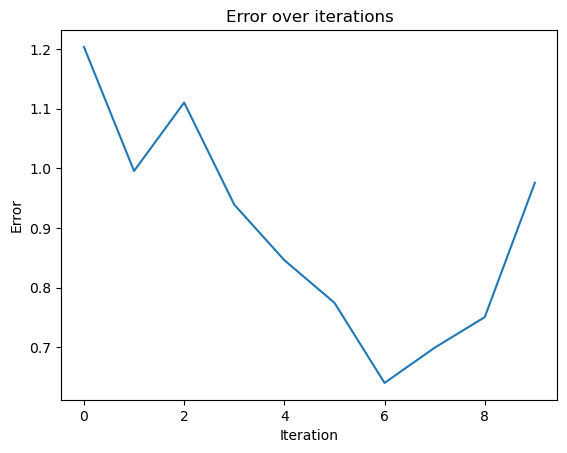

---------------------------------
3.6308654848800828


In [8]:

f1_score_f=[]
precison_f=[]
genetic_error=[]
recall_f=[]
mae_f=[]

from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn.preprocessing import LabelEncoder
# Import pandas and numpy
import pandas as pd
import numpy as np
import operator
import matplotlib.pyplot as plt

from settings import NO_OF_GENRES, NO_OF_FEATURES
import load_data
import fuzzy_sets
import gim
from genetic import genetic_optimize, cost_function
from Flowe_2 import flower_pollination_algorithm, cost_function;
from flower import flower_pollination_optimize, cost_function
# Constants
WEIGHTS=np.random.rand(NO_OF_FEATURES)
NO_OF_ITERATIONS=10
NO_OF_NEIGHBOURS=5

# namespace items_merged from load_data file
items_merged = load_data.items_merged

# Create objects for Age and GIM to use for fuzzy sets
age = fuzzy_sets.Age()
gim_obj = fuzzy_sets.GIM()

m_cols = ['unknown', 'Action', 'Adventure',
          'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
          'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', 'age',
          'user_id']

# Initialize empty dataFrames for active and passive users
model_data_active_users = pd.DataFrame(columns=m_cols)
model_data_passive_users = pd.DataFrame(columns=m_cols)


def euclidean_dist(list_a, list_b):
    """Return the Euclidean distance between two array elements."""
    return np.linalg.norm(np.array(list_a) - np.array(list_b))


def fuzzy_dist(first_point, second_point, fuzzy_set_first_point, fuzzy_set_second_point):
    """Returns fuzzy distance between two values and their fuzzy sets."""
    return abs(first_point - second_point) * euclidean_dist(fuzzy_set_first_point, fuzzy_set_second_point)


def fuzzy_distance(ui, uj):
   
  
    """Returns fuzzy distance between given points."""

    fuzzy_dis = [0] * NO_OF_FEATURES

    # Get fuzzy set values for movie genres
    for i in range(0, NO_OF_GENRES):

        ui_gim = gim_obj.get_fuzzy_set(int(ui.iloc[i]))
        uj_gim = gim_obj.get_fuzzy_set(int(uj.iloc[i]))
        fuzzy_dis[i] =fuzzy_dist(int(ui.iloc[i]), int(uj.iloc[i]), ui_gim, uj_gim)

    # Get fuzzy set values for age
    ui_gim = age.get_fuzzy_set(int(ui.iloc[i]))
    uj_gim = age.get_fuzzy_set(int(uj.iloc[i]))  # specify the column name here
    fuzzy_dis[i] = fuzzy_dist(int(ui.iloc[i]),int(uj.iloc[i]), ui_gim, uj_gim)

    # adding user_id of second user
    fuzzy_dis[NO_OF_FEATURES-1] = uj['user_id']
    
    return fuzzy_dis


def get_neighbours(model_active_users, model_passive_users):
    # Save active users and its neighbours in a data-frame with active users' id as column name
    user_neighbours= pd.DataFrame(columns=model_active_users['user_id'])
    #print("user",user_neighbours)
    # Iterate over active users model and save neighbours of each active users in user_neighbours
    for _, value in model_active_users.iterrows():
        j = 0
        fuzzy_vec = []
        for _, value_p in model_passive_users.iterrows():
            fuzzy_vec.append(fuzzy_distance(value, value_p))
            #print("fuzzy_vec",fuzzy_vec)
            #print(WEIGHTS[:-1])
            fuzzy_gen_dist = np.abs(np.sum(np.multiply(WEIGHTS[:-1], np.array(fuzzy_vec[j][:-1]))))
            fuzzy_vec[j] = [fuzzy_gen_dist, fuzzy_vec[j][-1]]
            j = j + 1
        user_neighbours[value.iloc[-1]] = [n[1] for n in sorted(fuzzy_vec, key=operator.itemgetter(0), reverse=True)][:NO_OF_NEIGHBOURS]
    return user_neighbours


def model_for_users(users_data):
    """Create model for given users data i.e. merged movies, items, and users
    Args:
        users_data: DataFrame of merged movies, items, and users based on movie_id
    """
    i = 0
    model_data_for_users = pd.DataFrame(columns=m_cols)
    
    for _, curr_value in users_data.iterrows():
        #print(curr_value)
        # Get user movies based on user
        user_movies = items_merged.loc[items_merged['user_id'] == curr_value['user_id']]
        #print("user movie",user_movies)
        # Get feature list for all movies of one user
        feature_array = gim.gim_final(user_movies, curr_value['user_id'])
        feature_array[NO_OF_GENRES] = curr_value['age']
        feature_array[NO_OF_GENRES + 1] = curr_value['user_id']

        # Save current feature values in model data
        model_data_for_users.loc[i] = feature_array
        i = i + 1
    return model_data_for_users

def correction_prediction(actual_ratings, predicted_ratings):
    """Correct predicted ratings based on actual ratings."""

    # Compute errors between actual and predicted ratings
    errors =errors = [actual - predicted for actual, predicted in zip(actual_ratings, predicted_ratings)]

    # Calculate mean error
    mean_error = np.mean(errors)

    # Apply correction to predicted ratings
    corrected_predictions = np.array([predicted_rating + mean_error for predicted_rating in predicted_ratings])

    return corrected_predictions
def recommend(nearest_neighbours, test_users_data):
    """Recommend rating for given movies i.e. test_examples based on nearest neighbours.
     
    Also return actual and predicated ratings for testing users
    """
    # print("nearest_neighbours")
    # print(nearest_neighbours)
    # print("test_users_data")
    # print(test_users_data.head())
    predicated_rat=[]
    actual_rat = []
    for key, item in test_users_data.iterrows():
        #print(item)
        
        m_id = item['movie_id']
        n_ratings = []
        for i in nearest_neighbours:

            # Get items or movie details reviewed by neighbour i with given m_id
            temp = items_merged.loc[items_merged['user_id'] == i].loc[items_merged['movie_id'] == m_id]
            for k, it in temp.iterrows():
                n_ratings.append(it['rating'])
        predicated_rat.append(float(sum(n_ratings)) / len(n_ratings) if len(n_ratings) else 0)
        actual_rat.append(item['rating'])
    return actual_rat, predicated_rat

# Users who has rated movies at least 60 movies
top_users = load_data.items_merged.groupby('user_id').size().sort_values(ascending=False)[:497]
 
model_error = []
f=[]
re=[]
pre=[]

# Train model for given iterations
for i in range(0, NO_OF_ITERATIONS):
    print(i)

    # Get random 10% of the top_users as active users and remaining are passive users
    active_users = top_users.sample(frac=0.10)

    # Random 34% of active users will be used for training and 66% users for testing purpose.
    training_active_users = active_users.sample(frac=0.34)
    #testing_active_users = active_users.drop(training_active_users.index)

    # passive_users will be used as training examples
    passive_users = top_users.drop(active_users.index)

    # Get active and passive users' data from merged movies, items, and users
    training_active_users_data = items_merged.loc[items_merged['user_id'].isin(training_active_users)][:10]
    test_active_users_data = items_merged.loc[items_merged['user_id'].isin(training_active_users)][10:]
    passive_users_data = items_merged.loc[items_merged['user_id'].isin(passive_users)][:10]

    # Get model for active users
    model_data_active_users = model_for_users(training_active_users_data)

    # Get model for passive users
    model_data_passive_users = model_for_users(passive_users_data)

    # Get neighbour users of active users
    active_users_neighbours = get_neighbours(model_data_active_users, model_data_passive_users)

    # Recommend users based on neighbours
    actual_ratings, predicated_ratings=recommend(active_users_neighbours, test_active_users_data)

    # Get error for predictions of test users
    cur_error = cost_function(actual_ratings, predicated_ratings)

    # Optimize weights using genetic algorithm approach and update weighs
    #WEIGHTS  =genetic_optimize(actual_ratings, predicated_ratings).flatten()
    # print(predicated_ratings)
    
    WEIGHTS  =flower_pollination_optimize(actual_ratings, predicated_ratings).flatten()
    # Add current iteration error to model error for MAE of the model
    
    model_error.append(cost_function(actual_ratings, predicated_ratings))
    pred=[int(num) for num in predicated_ratings]
    f.append(f1_score(actual_ratings, pred, average='micro'))
    pre.append(precision_score(actual_ratings, pred, average='micro'))
    re.append(recall_score(actual_ratings, pred, average='micro'))
    # Log details for current iteration
    print("Iteration : ", i)
    print("Error: ", cur_error)
    print('Weights after iteration is: ', WEIGHTS)
print("Mean absolute error for all iterations: ", sum(model_error)/len(model_error))

f1_score_f=f
precison_f=pre
recall_f=re
mae_f=model_error
#average of erro overt the time 
plt.plot(model_error)
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title('Error over iterations')
plt.show()
print("---------------------------------")
print(np.mean(correction_prediction(actual_ratings, predicated_ratings)))
pred=[int(num) for num in predicated_ratings]

# Assuming model_error is your list
# replace with your list

# Assuming model_error is your list
# replace with your list


In [9]:
f1_a.append(f1_score(actual_ratings, pred, average='micro'))
pre_a.append(precision_score(actual_ratings, pred, average='micro'))
rec_a.append(recall_score(actual_ratings, pred, average='micro'))

0
Iteration :  0
Error:  0.8374353526899724
Weights after iteration is:  [0.41429542 0.02277961 0.43189243 0.18996662 0.72535571 0.03123159
 0.45297518 0.40557691 0.57368241 0.04938891 0.9991487  0.4280048
 0.1196639  0.35549068 0.72930089 0.4334319  0.61101186 0.54187843
 0.48051768 0.31040256 0.43034598]
1
Iteration :  1
Error:  0.7487128703466226
Weights after iteration is:  [0.96570929 0.27569573 0.62236393 0.25223724 0.38848296 0.07358072
 0.81023549 0.2664292  0.00733758 0.396843   0.23767048 0.00131314
 0.13328542 0.22162382 0.44315231 0.82077808 0.37906969 0.04926258
 0.35812131 0.04890941 0.91598839]
2
Iteration :  2
Error:  0.9952087007642568
Weights after iteration is:  [0.36234954 0.39256379 0.6630594  0.43144829 0.38480626 0.74039752
 0.80743596 0.16358727 0.24083614 0.16977434 0.23770849 0.44794095
 0.01716465 0.12425838 0.69707051 0.78551954 0.30775645 0.21695952
 0.96010165 0.10927691 0.56474099]
3
Iteration :  3
Error:  0.8378291812802062
Weights after iteration is:  [

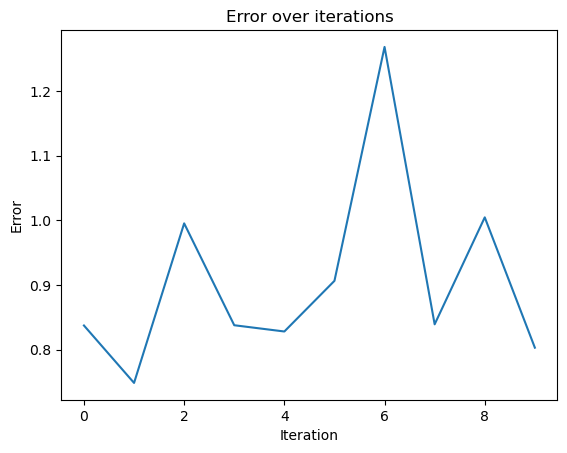

---------------------------------
3.562686567164179


In [10]:
f1_score_f=[]
precison_f=[]
genetic_error=[]
recall_f=[]
mae_f=[]

from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn.preprocessing import LabelEncoder
# Import pandas and numpy
import pandas as pd
import numpy as np
import operator
import matplotlib.pyplot as plt

from settings import NO_OF_GENRES, NO_OF_FEATURES
import load_data
import fuzzy_sets
import gim
from genetic import genetic_optimize, cost_function
from Flowe_2 import flower_pollination_algorithm, cost_function;
from flower import flower_pollination_optimize, cost_function
# Constants
WEIGHTS=np.random.rand(NO_OF_FEATURES)
NO_OF_ITERATIONS=10
NO_OF_NEIGHBOURS=10

# namespace items_merged from load_data file
items_merged = load_data.items_merged

# Create objects for Age and GIM to use for fuzzy sets
age = fuzzy_sets.Age()
gim_obj = fuzzy_sets.GIM()

m_cols = ['unknown', 'Action', 'Adventure',
          'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
          'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', 'age',
          'user_id']

# Initialize empty dataFrames for active and passive users
model_data_active_users = pd.DataFrame(columns=m_cols)
model_data_passive_users = pd.DataFrame(columns=m_cols)


def euclidean_dist(list_a, list_b):
    """Return the Euclidean distance between two array elements."""
    return np.linalg.norm(np.array(list_a) - np.array(list_b))


def fuzzy_dist(first_point, second_point, fuzzy_set_first_point, fuzzy_set_second_point):
    """Returns fuzzy distance between two values and their fuzzy sets."""
    return abs(first_point - second_point) * euclidean_dist(fuzzy_set_first_point, fuzzy_set_second_point)


def fuzzy_distance(ui, uj):
   
  
    """Returns fuzzy distance between given points."""

    fuzzy_dis = [0] * NO_OF_FEATURES

    # Get fuzzy set values for movie genres
    for i in range(0, NO_OF_GENRES):

        ui_gim = gim_obj.get_fuzzy_set(int(ui.iloc[i]))
        uj_gim = gim_obj.get_fuzzy_set(int(uj.iloc[i]))
        fuzzy_dis[i] =fuzzy_dist(int(ui.iloc[i]), int(uj.iloc[i]), ui_gim, uj_gim)

    # Get fuzzy set values for age
    ui_gim = age.get_fuzzy_set(int(ui.iloc[i]))
    uj_gim = age.get_fuzzy_set(int(uj.iloc[i]))  # specify the column name here
    fuzzy_dis[i] = fuzzy_dist(int(ui.iloc[i]),int(uj.iloc[i]), ui_gim, uj_gim)

    # adding user_id of second user
    fuzzy_dis[NO_OF_FEATURES-1] = uj['user_id']
    
    return fuzzy_dis


def get_neighbours(model_active_users, model_passive_users):
    # Save active users and its neighbours in a data-frame with active users' id as column name
    user_neighbours= pd.DataFrame(columns=model_active_users['user_id'])
    #print("user",user_neighbours)
    # Iterate over active users model and save neighbours of each active users in user_neighbours
    for _, value in model_active_users.iterrows():
        j = 0
        fuzzy_vec = []
        for _, value_p in model_passive_users.iterrows():
            fuzzy_vec.append(fuzzy_distance(value, value_p))
            #print("fuzzy_vec",fuzzy_vec)
            #print(WEIGHTS[:-1])
            fuzzy_gen_dist = np.abs(np.sum(np.multiply(WEIGHTS[:-1], np.array(fuzzy_vec[j][:-1]))))
            fuzzy_vec[j] = [fuzzy_gen_dist, fuzzy_vec[j][-1]]
            j = j + 1
        user_neighbours[value.iloc[-1]] = [n[1] for n in sorted(fuzzy_vec, key=operator.itemgetter(0), reverse=True)][:NO_OF_NEIGHBOURS]
    return user_neighbours


def model_for_users(users_data):
    """Create model for given users data i.e. merged movies, items, and users
    Args:
        users_data: DataFrame of merged movies, items, and users based on movie_id
    """
    i = 0
    model_data_for_users = pd.DataFrame(columns=m_cols)
    
    for _, curr_value in users_data.iterrows():
        #print(curr_value)
        # Get user movies based on user
        user_movies = items_merged.loc[items_merged['user_id'] == curr_value['user_id']]
        #print("user movie",user_movies)
        # Get feature list for all movies of one user
        feature_array = gim.gim_final(user_movies, curr_value['user_id'])
        feature_array[NO_OF_GENRES] = curr_value['age']
        feature_array[NO_OF_GENRES + 1] = curr_value['user_id']

        # Save current feature values in model data
        model_data_for_users.loc[i] = feature_array
        i = i + 1
    return model_data_for_users

def correction_prediction(actual_ratings, predicted_ratings):
    """Correct predicted ratings based on actual ratings."""

    # Compute errors between actual and predicted ratings
    errors =errors = [actual - predicted for actual, predicted in zip(actual_ratings, predicted_ratings)]

    # Calculate mean error
    mean_error = np.mean(errors)

    # Apply correction to predicted ratings
    corrected_predictions = np.array([predicted_rating + mean_error for predicted_rating in predicted_ratings])

    return corrected_predictions
def recommend(nearest_neighbours, test_users_data):
    """Recommend rating for given movies i.e. test_examples based on nearest neighbours.
     
    Also return actual and predicated ratings for testing users
    """
    # print("nearest_neighbours")
    # print(nearest_neighbours)
    # print("test_users_data")
    # print(test_users_data.head())
    predicated_rat=[]
    actual_rat = []
    for key, item in test_users_data.iterrows():
        #print(item)
        
        m_id = item['movie_id']
        n_ratings = []
        for i in nearest_neighbours:

            # Get items or movie details reviewed by neighbour i with given m_id
            temp = items_merged.loc[items_merged['user_id'] == i].loc[items_merged['movie_id'] == m_id]
            for k, it in temp.iterrows():
                n_ratings.append(it['rating'])
        predicated_rat.append(float(sum(n_ratings)) / len(n_ratings) if len(n_ratings) else 0)
        actual_rat.append(item['rating'])
    return actual_rat, predicated_rat

# Users who has rated movies at least 60 movies
top_users = load_data.items_merged.groupby('user_id').size().sort_values(ascending=False)[:497]
 
model_error = []
f=[]
re=[]
pre=[]

# Train model for given iterations
for i in range(0, NO_OF_ITERATIONS):
    print(i)

    # Get random 10% of the top_users as active users and remaining are passive users
    active_users = top_users.sample(frac=0.10)

    # Random 34% of active users will be used for training and 66% users for testing purpose.
    training_active_users = active_users.sample(frac=0.34)
    #testing_active_users = active_users.drop(training_active_users.index)

    # passive_users will be used as training examples
    passive_users = top_users.drop(active_users.index)

    # Get active and passive users' data from merged movies, items, and users
    training_active_users_data = items_merged.loc[items_merged['user_id'].isin(training_active_users)][:10]
    test_active_users_data = items_merged.loc[items_merged['user_id'].isin(training_active_users)][10:]
    passive_users_data = items_merged.loc[items_merged['user_id'].isin(passive_users)][:10]

    # Get model for active users
    model_data_active_users = model_for_users(training_active_users_data)

    # Get model for passive users
    model_data_passive_users = model_for_users(passive_users_data)

    # Get neighbour users of active users
    active_users_neighbours = get_neighbours(model_data_active_users, model_data_passive_users)

    # Recommend users based on neighbours
    actual_ratings, predicated_ratings=recommend(active_users_neighbours, test_active_users_data)

    # Get error for predictions of test users
    cur_error = cost_function(actual_ratings, predicated_ratings)

    # Optimize weights using genetic algorithm approach and update weighs
    #WEIGHTS  =genetic_optimize(actual_ratings, predicated_ratings).flatten()
    # print(predicated_ratings)
    
    WEIGHTS  =flower_pollination_optimize(actual_ratings, predicated_ratings).flatten()
    # Add current iteration error to model error for MAE of the model
    
    model_error.append(cost_function(actual_ratings, predicated_ratings))
    pred=[int(num) for num in predicated_ratings]
    f.append(f1_score(actual_ratings, pred, average='micro'))
    pre.append(precision_score(actual_ratings, pred, average='micro'))
    re.append(recall_score(actual_ratings, pred, average='micro'))
    # Log details for current iteration
    print("Iteration : ", i)
    print("Error: ", cur_error)
    print('Weights after iteration is: ', WEIGHTS)
print("Mean absolute error for all iterations: ", sum(model_error)/len(model_error))

f1_score_f=f
precison_f=pre
recall_f=re
mae_f=model_error
#average of erro overt the time 
plt.plot(model_error)
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title('Error over iterations')
plt.show()
print("---------------------------------")
print(np.mean(correction_prediction(actual_ratings, predicated_ratings)))
pred=[int(num) for num in predicated_ratings]
f1_a.append(f1_score(actual_ratings, pred, average='micro'))
pre_a.append(precision_score(actual_ratings, pred, average='micro'))
rec_a.append(recall_score(actual_ratings, pred, average='micro'))
# Assuming model_error is your list
# replace with your list

# Assuming model_error is your list
# replace with your list

0
Iteration :  0
Error:  0.8027054695808612
1
Iteration :  1
Error:  0.9655205545261127
2
Iteration :  2
Error:  0.853428778918975
3
Iteration :  3
Error:  0.7274009702793083
4
Iteration :  4
Error:  0.8923020472678006
5
Iteration :  5
Error:  0.8208617470957513
6
Iteration :  6
Error:  0.836640878013674
7
Iteration :  7
Error:  0.7076991942703672
8
Iteration :  8
Error:  0.8395896607131254
9
Iteration :  9
Error:  0.6213969944703029
Mean absolute error for all iterations:  0.8067546295136279


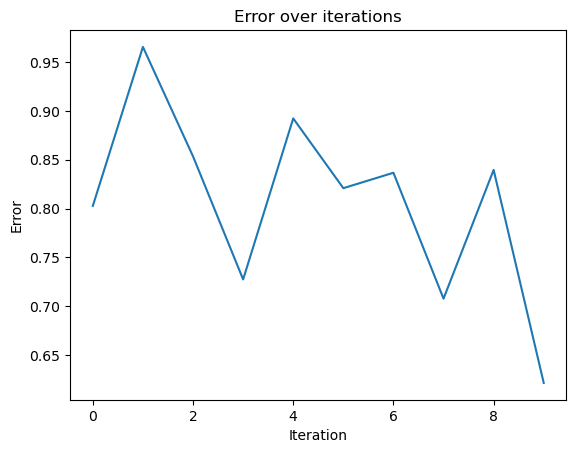

---------------------------------
3.473684210526316


In [11]:
f1_score_f=[]
precison_f=[]
genetic_error=[]
recall_f=[]
mae_f=[]

from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn.preprocessing import LabelEncoder
# Import pandas and numpy
import pandas as pd
import numpy as np
import operator
import matplotlib.pyplot as plt

from settings import NO_OF_GENRES, NO_OF_FEATURES
import load_data
import fuzzy_sets
import gim
from genetic import genetic_optimize, cost_function
from Flowe_2 import flower_pollination_algorithm, cost_function;
from flower import flower_pollination_optimize, cost_function
# Constants
WEIGHTS=np.random.rand(NO_OF_FEATURES)
NO_OF_ITERATIONS=10
NO_OF_NEIGHBOURS=15

# namespace items_merged from load_data file
items_merged = load_data.items_merged

# Create objects for Age and GIM to use for fuzzy sets
age = fuzzy_sets.Age()
gim_obj = fuzzy_sets.GIM()

m_cols = ['unknown', 'Action', 'Adventure',
          'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
          'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', 'age',
          'user_id']

# Initialize empty dataFrames for active and passive users
model_data_active_users = pd.DataFrame(columns=m_cols)
model_data_passive_users = pd.DataFrame(columns=m_cols)


def euclidean_dist(list_a, list_b):
    """Return the Euclidean distance between two array elements."""
    return np.linalg.norm(np.array(list_a) - np.array(list_b))


def fuzzy_dist(first_point, second_point, fuzzy_set_first_point, fuzzy_set_second_point):
    """Returns fuzzy distance between two values and their fuzzy sets."""
    return abs(first_point - second_point) * euclidean_dist(fuzzy_set_first_point, fuzzy_set_second_point)


def fuzzy_distance(ui, uj):
   
  
    """Returns fuzzy distance between given points."""

    fuzzy_dis = [0] * NO_OF_FEATURES

    # Get fuzzy set values for movie genres
    for i in range(0, NO_OF_GENRES):

        ui_gim = gim_obj.get_fuzzy_set(int(ui.iloc[i]))
        uj_gim = gim_obj.get_fuzzy_set(int(uj.iloc[i]))
        fuzzy_dis[i] =fuzzy_dist(int(ui.iloc[i]), int(uj.iloc[i]), ui_gim, uj_gim)

    # Get fuzzy set values for age
    ui_gim = age.get_fuzzy_set(int(ui.iloc[i]))
    uj_gim = age.get_fuzzy_set(int(uj.iloc[i]))  # specify the column name here
    fuzzy_dis[i] = fuzzy_dist(int(ui.iloc[i]),int(uj.iloc[i]), ui_gim, uj_gim)

    # adding user_id of second user
    fuzzy_dis[NO_OF_FEATURES-1] = uj['user_id']
    
    return fuzzy_dis


def get_neighbours(model_active_users, model_passive_users):
    # Save active users and its neighbours in a data-frame with active users' id as column name
    user_neighbours= pd.DataFrame(columns=model_active_users['user_id'])
    #print("user",user_neighbours)
    # Iterate over active users model and save neighbours of each active users in user_neighbours
    for _, value in model_active_users.iterrows():
        j = 0
        fuzzy_vec = []
        for _, value_p in model_passive_users.iterrows():
            fuzzy_vec.append(fuzzy_distance(value, value_p))
            #print("fuzzy_vec",fuzzy_vec)
            #print(WEIGHTS[:-1])
            fuzzy_gen_dist = np.abs(np.sum(np.multiply(WEIGHTS[:-1], np.array(fuzzy_vec[j][:-1]))))
            fuzzy_vec[j] = [fuzzy_gen_dist, fuzzy_vec[j][-1]]
            j = j + 1
        user_neighbours[value.iloc[-1]] = [n[1] for n in sorted(fuzzy_vec, key=operator.itemgetter(0), reverse=True)][:NO_OF_NEIGHBOURS]
    return user_neighbours


def model_for_users(users_data):
    """Create model for given users data i.e. merged movies, items, and users
    Args:
        users_data: DataFrame of merged movies, items, and users based on movie_id
    """
    i = 0
    model_data_for_users = pd.DataFrame(columns=m_cols)
    
    for _, curr_value in users_data.iterrows():
        #print(curr_value)
        # Get user movies based on user
        user_movies = items_merged.loc[items_merged['user_id'] == curr_value['user_id']]
        #print("user movie",user_movies)
        # Get feature list for all movies of one user
        feature_array = gim.gim_final(user_movies, curr_value['user_id'])
        feature_array[NO_OF_GENRES] = curr_value['age']
        feature_array[NO_OF_GENRES + 1] = curr_value['user_id']

        # Save current feature values in model data
        model_data_for_users.loc[i] = feature_array
        i = i + 1
    return model_data_for_users

def correction_prediction(actual_ratings, predicted_ratings):
    """Correct predicted ratings based on actual ratings."""

    # Compute errors between actual and predicted ratings
    errors =errors = [actual - predicted for actual, predicted in zip(actual_ratings, predicted_ratings)]

    # Calculate mean error
    mean_error = np.mean(errors)

    # Apply correction to predicted ratings
    corrected_predictions = np.array([predicted_rating + mean_error for predicted_rating in predicted_ratings])

    return corrected_predictions
def recommend(nearest_neighbours, test_users_data):
    """Recommend rating for given movies i.e. test_examples based on nearest neighbours.
     
    Also return actual and predicated ratings for testing users
    """
    # print("nearest_neighbours")
    # print(nearest_neighbours)
    # print("test_users_data")
    # print(test_users_data.head())
    predicated_rat=[]
    actual_rat = []
    for key, item in test_users_data.iterrows():
        #print(item)
        
        m_id = item['movie_id']
        n_ratings = []
        for i in nearest_neighbours:

            # Get items or movie details reviewed by neighbour i with given m_id
            temp = items_merged.loc[items_merged['user_id'] == i].loc[items_merged['movie_id'] == m_id]
            for k, it in temp.iterrows():
                n_ratings.append(it['rating'])
        predicated_rat.append(float(sum(n_ratings)) / len(n_ratings) if len(n_ratings) else 0)
        actual_rat.append(item['rating'])
    return actual_rat, predicated_rat

# Users who has rated movies at least 60 movies
top_users = load_data.items_merged.groupby('user_id').size().sort_values(ascending=False)[:497]
 
model_error = []
f=[]
re=[]
pre=[]

# Train model for given iterations
for i in range(0, NO_OF_ITERATIONS):
    print(i)

    # Get random 10% of the top_users as active users and remaining are passive users
    active_users = top_users.sample(frac=0.10)

    # Random 34% of active users will be used for training and 66% users for testing purpose.
    training_active_users = active_users.sample(frac=0.34)
    #testing_active_users = active_users.drop(training_active_users.index)

    # passive_users will be used as training examples
    passive_users = top_users.drop(active_users.index)

    # Get active and passive users' data from merged movies, items, and users
    training_active_users_data = items_merged.loc[items_merged['user_id'].isin(training_active_users)][:10]
    test_active_users_data = items_merged.loc[items_merged['user_id'].isin(training_active_users)][10:]
    passive_users_data = items_merged.loc[items_merged['user_id'].isin(passive_users)][:10]

    # Get model for active users
    model_data_active_users = model_for_users(training_active_users_data)

    # Get model for passive users
    model_data_passive_users = model_for_users(passive_users_data)

    # Get neighbour users of active users
    active_users_neighbours = get_neighbours(model_data_active_users, model_data_passive_users)

    # Recommend users based on neighbours
    actual_ratings, predicated_ratings=recommend(active_users_neighbours, test_active_users_data)

    # Get error for predictions of test users
    cur_error = cost_function(actual_ratings, predicated_ratings)

    # Optimize weights using genetic algorithm approach and update weighs
    #WEIGHTS  =genetic_optimize(actual_ratings, predicated_ratings).flatten()
    # print(predicated_ratings)
    
    WEIGHTS  =flower_pollination_optimize(actual_ratings, predicated_ratings).flatten()
    # Add current iteration error to model error for MAE of the model
    
    model_error.append(cost_function(actual_ratings, predicated_ratings))
    pred=[int(num) for num in predicated_ratings]
    f.append(f1_score(actual_ratings, pred, average='micro'))
    pre.append(precision_score(actual_ratings, pred, average='micro'))
    re.append(recall_score(actual_ratings, pred, average='micro'))
    # Log details for current iteration
    print("Iteration : ", i)
    print("Error: ", cur_error)
   
print("Mean absolute error for all iterations: ", sum(model_error)/len(model_error))

f1_score_f=f
precison_f=pre
recall_f=re
mae_f=model_error
#average of erro overt the time 
plt.plot(model_error)
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title('Error over iterations')
plt.show()
print("---------------------------------")
print(np.mean(correction_prediction(actual_ratings, predicated_ratings)))
pred=[int(num) for num in predicated_ratings]
f1_a.append(f1_score(actual_ratings, pred, average='micro'))
pre_a.append(precision_score(actual_ratings, pred, average='micro'))
rec_a.append(recall_score(actual_ratings, pred, average='micro'))
# Assuming model_error is your list
# replace with your list

# Assuming model_error is your list
# replace with your list

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (3,) and arg 1 with shape (10,).

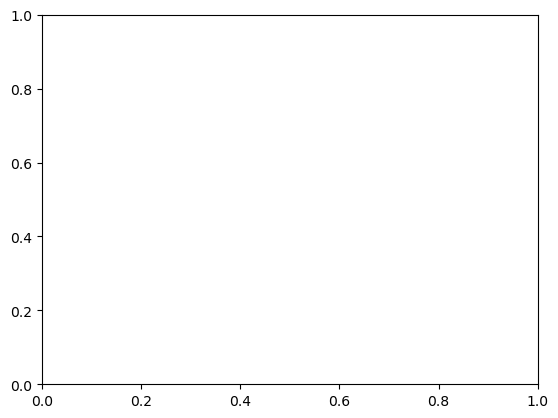

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming flower_error, genetic_error and fuzzy_error are your data


# Create an array with the positions of each bar along the x-axis
x = np.arange(len(f1_a))

# Plot the bars
fig, ax = plt.subplots()
bar_width = 0.4  # Reduced bar width to fit three bars

rects1 = ax.bar(x - bar_width, mae_f, bar_width, label='Flower',color='blue')
rects2 = ax.bar(x, mae, bar_width, label='Genetic',color='Green')
# rects3 = ax.bar(x + bar_width, fuzzy_error, bar_width, label='Fuzzy')  # Added third bar

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Iteration')
ax.set_ylabel('Error')
ax.set_title('Error over iterations for Flower, Genetic and Fuzzy algorithms')
ax.set_xticks(x)
ax.legend()
fig.tight_layout()
plt.show()

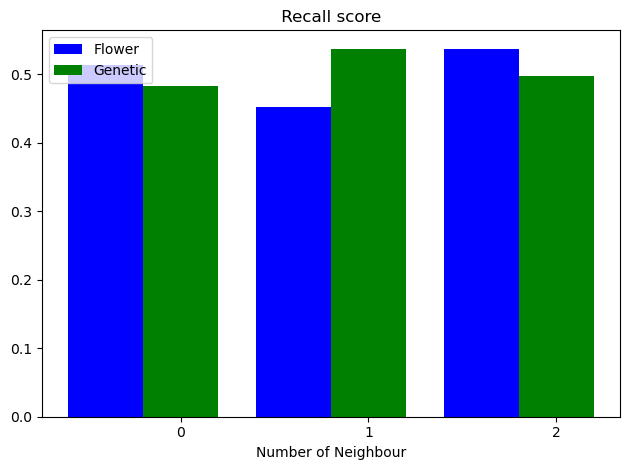

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming flower_error, genetic_error and fuzzy_error are your data


# Create an array with the positions of each bar along the x-axis
x = np.arange(len(rec_a))

# Plot the bars
fig, ax = plt.subplots()
bar_width = 0.4  # Reduced bar width to fit three bars

rects1 = ax.bar(x - bar_width,rec_a, bar_width, label='Flower',color='blue')
rects2 = ax.bar(x, recall_s, bar_width, label='Genetic',color='Green')
# rects3 = ax.bar(x + bar_width, fuzzy_error, bar_width, label='Fuzzy')  # Added third bar

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Number of Neighbour')
# ax.set_ylabel('')
ax.set_title(' Recall score ')
ax.set_xticks(x)
ax.legend()
fig.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming flower_error, genetic_error and fuzzy_error are your data


# Create an array with the positions of each bar along the x-axis
x = np.arange(len(precison_f))

# Plot the bars
fig, ax = plt.subplots()
bar_width = 0.4  # Reduced bar width to fit three bars

rects1 = ax.bar(x - bar_width,precison_f, bar_width, label='Flower',color='blue')
rects2 = ax.bar(x, precison, bar_width, label='Genetic',color='Green')
# rects3 = ax.bar(x + bar_width, fuzzy_error, bar_width, label='Fuzzy')  # Added third bar

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Iteration')
ax.set_ylabel('Error')
ax.set_title('precison score over iterations for Flower, Genetic ')
ax.set_xticks(x)
ax.legend()
fig.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming flower_error, genetic_error and fuzzy_error are your data


# Create an array with the positions of each bar along the x-axis
x = np.arange(len(precison_f))

# Plot the bars
fig, ax = plt.subplots()
bar_width = 0.4  # Reduced bar width to fit three bars

rects1 = ax.bar(x - bar_width,precison_f, bar_width, label='Flower',color='blue')
rects2 = ax.bar(x, precison, bar_width, label='Genetic',color='Green')
# rects3 = ax.bar(x + bar_width, fuzzy_error, bar_width, label='Fuzzy')  # Added third bar

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Iteration')
ax.set_ylabel('Error')
ax.set_title('precison score over iterations for Flower, Genetic ')
ax.set_xticks(x)
ax.legend()
fig.tight_layout()
plt.show()

In [20]:
print(f1_s)

[0.4822485207100592, 0.5371396895787139, 0.49753937007874016]
